# GANs - Monet Painting Dataset Assignment
## ("I'm Something of a Painter Myself" on Kaggle)
## by: Kevin Boyle (CU-B MS-DS)

### Introduction / Brief Description of the Problem and Data

Hello! For this project, I will be taking a dataset filled with pictures of Monet paintings. With that information, I will be utilizing GANs to generate new images in the style of a Monet painting.

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. This generator is trained using a discriminator. The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real versus generated images.

Using a GAN and the dataset, I will attempt to generate about 7000-10000 new images. I will see if we can create whole new images that look just like the style of Monet!

The dataset comes from this Kaggle link (which also includes the competition as a whole): https://www.kaggle.com/competitions/gan-getting-started/data

##### To start, I am going to import all relevant libraries I may be using throughout the project, as well as reading the images into the jupyter notebook.

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, zipfile
import seaborn as sns
import random
import os
import xml.etree.ElementTree as ET 
import PIL
from PIL import Image
import time
import shutil
from IPython import display
import tensorflow as tf
from tensorflow.keras import utils, layers, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization, Input, Conv2D, Flatten, Reshape, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Exploratory Data Analysis (EDA)

I will now check a few datapoints on the different photo directories, as well as visualizing some of these images so we can see what we are working with.

In [147]:
PATH = '../downloads/gan-getting-started'
IMAGE_SIZE = [256,256]

photos_to_mod_dir = str(PATH + '/photo_jpg')
monet_train_dir = str(PATH + '/monet_jpg')

In [148]:
print('Photos to Modify Count:', len(os.listdir(photos_to_mod_dir)))
print('Real Monet Photos Count:', len(os.listdir(monet_train_dir)))

Photos to Modify Count: 7038
Real Monet Photos Count: 300


In [149]:
idxIn = 0
monetIn = np.zeros((300,256,256,3))

monet_train = os.listdir(monet_train_dir)

for monet in monet_train:
    img = Image.open(monet_train_dir+'/'+monet)
    monetIn[idxIn,:,:,:] = np.asarray(img)
    idxIn += 1

In [151]:
idxIn = 0
photosModIn = np.zeros((7038,256,256,3))

photos_to_mod = os.listdir(photos_to_mod_dir)

for photo in photos_to_mod:
    img = Image.open(photos_to_mod_dir+'/'+photo)
    photosModIn[idxIn,:,:,:] = np.asarray(img)
    idxIn += 1

Now that I know there are 300 real monet photos, I am going to display a grid of 25 of them at random to show what we are working with.

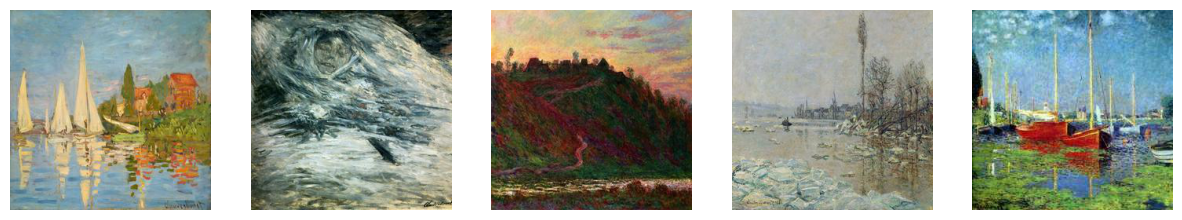

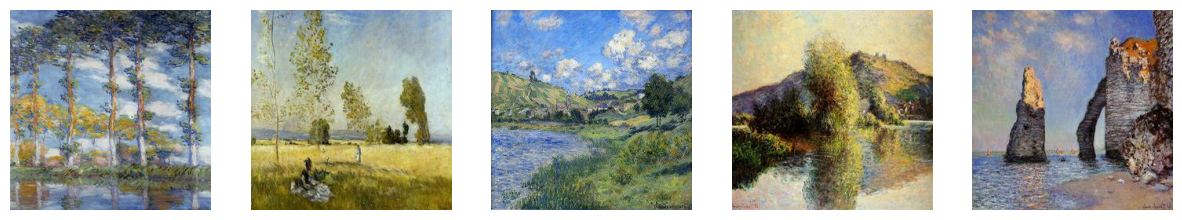

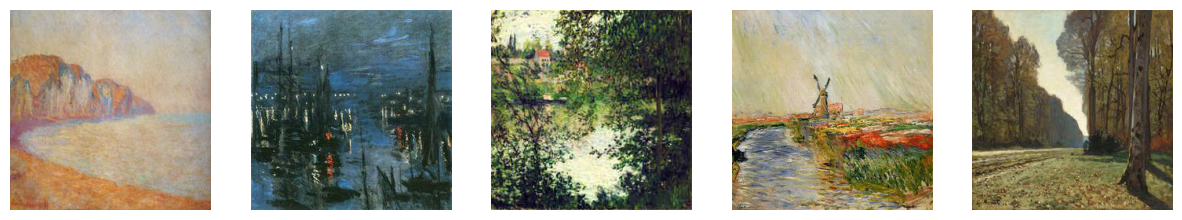

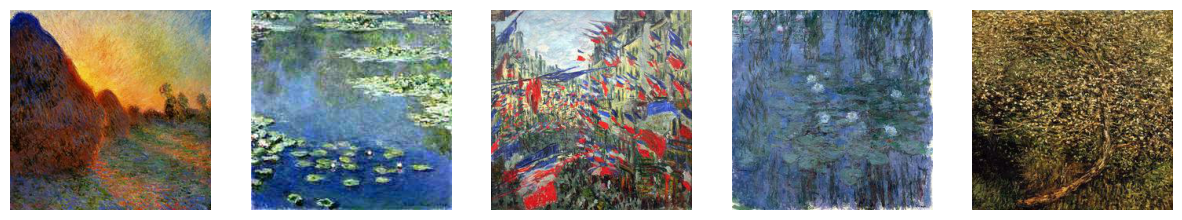

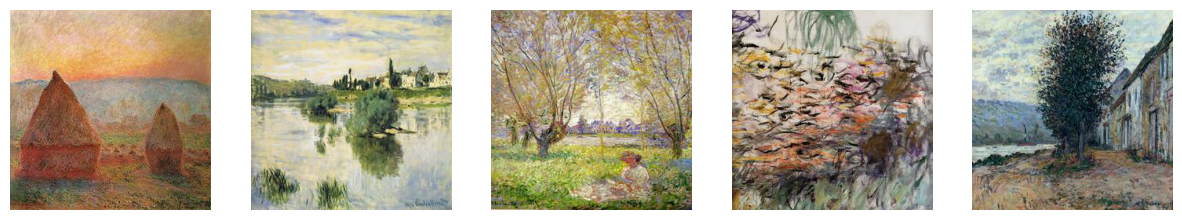

In [152]:
num = 0
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray(monetIn[num,:,:,:].astype('uint8') )
        num += 1
        plt.axis('off')
        plt.imshow(img)
    plt.show();

And now that we know there are over 7000 photos to modify, I am going to display 25 of those as well at random to see what kind of photos we should be modifying.

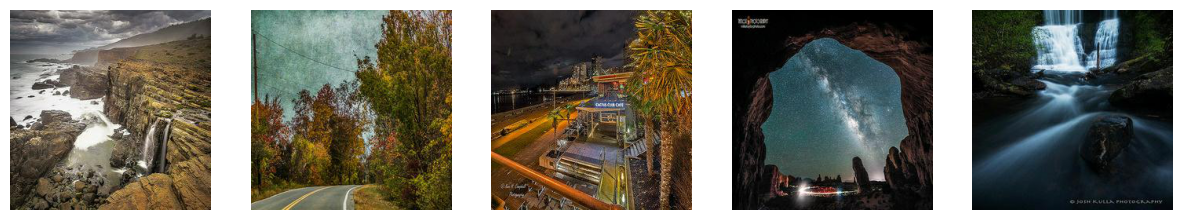

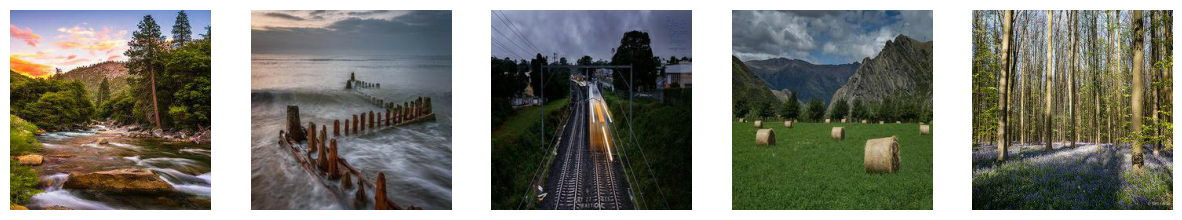

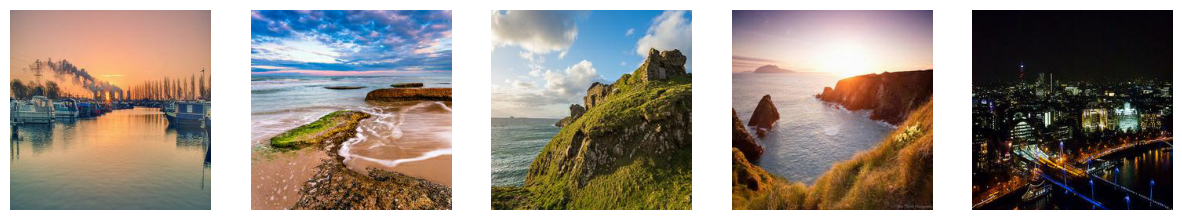

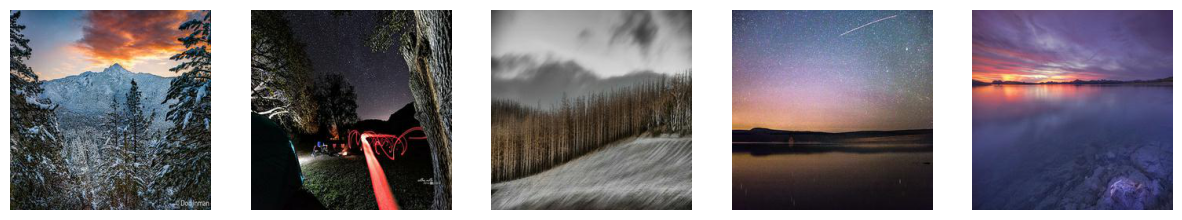

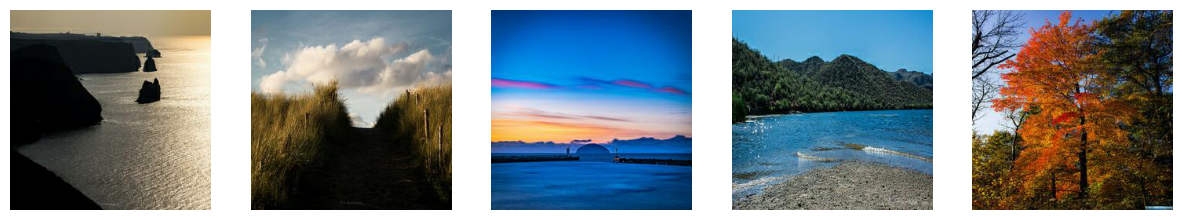

In [153]:
num = 0
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray(photosModIn[num,:,:,:].astype('uint8') )
        num += 1
        plt.axis('off')
        plt.imshow(img)
    plt.show();

For the purposes of this model, we will use the tfrec files.

In [154]:
monet_names = tf.io.gfile.glob(str(PATH + '/monet_tfrec/*.tfrec'))
photo_names = tf.io.gfile.glob(str(PATH + '/photo_tfrec/*.tfrec'))

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

monet_data = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_data = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

### Model Architecture

I will now begin to train our GAN model. We have decoded, read, and loaded the images, which we will use training data. Now, we will declare two models: a generator, and a discriminator. The generator will create images and try to trick the discriminator. The discriminator, in turn, will decide which images are real or fake.

Our goal is to trick the discriminator such that it thinks our generated, revised images are actually real Monet images. Overall, we will use 50 epochs, which we hope will be enough to train the models. 

Our generator will have multiple convolutional 2D layers using activation functions of relu and tanh. There will be padding equal to 'same' so that the output images match the input images.

In [155]:
def create_generator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,4,strides=2, padding='same', activation='relu', input_shape=[256,256,3]))
    model.add(layers.Conv2D(128,4,strides=2, padding='same', activation='relu',use_bias=False))
    model.add(layers.Conv2D(256,4,strides=2, padding='same', activation='relu',use_bias=False))
    model.add(layers.Conv2D(512,4, strides=2, padding='same', activation='relu',use_bias=False))       
    model.add(layers.Conv2DTranspose(256, 4, strides=2,padding='same', activation='relu', use_bias=False))          
    model.add(layers.Conv2DTranspose(128, 4, strides=2,padding='same', activation='relu', use_bias=False))          
    model.add(layers.Conv2DTranspose( 64, 4, strides=2,padding='same', activation='relu', use_bias=False))          
    model.add(layers.Conv2DTranspose(  3, 4, strides=2,padding='same', activation='tanh', use_bias=False))          
    return model

Our discriminator model has convolutional 2D layers as well with relu activation functions.

In [156]:
def create_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,4,strides=2, padding='same', activation='relu', input_shape=[256,256,3]))
    model.add(layers.Conv2D(128,4,strides=2, padding='same', activation='relu',use_bias=False))
    model.add(layers.Conv2D(256,4,strides=2, padding='same', activation='relu',use_bias=False))
    model.add(layers.Conv2D(1,4,strides=1, padding='valid', activation='relu',use_bias=False))
    return model

We will create the four instances we need based on the create functions above. We will create two generators, one for monet so that we tranform photos into monet paintings, and one for photo so that we tranform Monet paintings to be more like regular photos.

Finally, we create two discriminators as well. One differentiates real Monet paintings and generated Monet paintings, and one differentiates real photos and generated photos.

In [157]:
monet_generator = create_generator()
photo_generator = create_generator() 

monet_discriminator = create_discriminator() 
photo_discriminator = create_discriminator() 

Next is the CycleGan class we are creating to be the backbone of the entire model. For more information on the CycleGAN class, please refer to the Keras.io website: https://keras.io/examples/generative/cyclegan/

In [158]:
class CycleGan(tf.keras.Model):
    def __init__(self, generator_m, generator_p, discriminator_m, discriminator_p, lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.gen_m = generator_m
        self.gen_p = generator_p
        self.disc_m = discriminator_m
        self.disc_p = discriminator_p
        self.lambda_cycle = lambda_cycle
        
    def compile(self, gen_m_optimizer, gen_p_optimizer, disc_m_optimizer, disc_p_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.gen_m_optimizer = gen_m_optimizer
        self.gen_p_optimizer = gen_p_optimizer
        self.disc_m_optimizer = disc_m_optimizer
        self.disc_p_optimizer = disc_p_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.gen_m(real_photo, training=True)
            cycled_photo = self.gen_p(fake_monet, training=True)

            fake_photo = self.gen_p(real_monet, training=True)
            cycled_monet = self.gen_m(fake_photo, training=True)

            same_monet = self.gen_m(real_monet, training=True)
            same_photo = self.gen_p(real_photo, training=True)

            disc_real_monet = self.disc_m(real_monet, training=True)
            disc_real_photo = self.disc_p(real_photo, training=True)

            disc_fake_monet = self.disc_m(fake_monet, training=True)
            disc_fake_photo = self.disc_p(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            
            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.gen_m.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.gen_p.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.disc_m.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.disc_p.trainable_variables)
        
        # Apply the gradients to the optimizer
        self.gen_m_optimizer.apply_gradients(zip(monet_generator_gradients, self.gen_m.trainable_variables))

        self.gen_p_optimizer.apply_gradients(zip(photo_generator_gradients, self.gen_p.trainable_variables))

        self.disc_m_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.disc_m.trainable_variables))

        self.disc_p_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.disc_p.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss, 
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

For the various losses, we will utilizing Binary Crossentropy.

In [159]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [160]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [161]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [162]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

Now that everything is defined, I will be creating an instance of the model, and then compiling that model.

For every generator/discriminator, I will be using a legacy optimizer.

In [163]:
model_optimizer = tf.keras.optimizers.legacy.Adam()

cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    gen_m_optimizer = model_optimizer,
    gen_p_optimizer = model_optimizer,
    disc_m_optimizer = model_optimizer,
    disc_p_optimizer = model_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

I will fit the model with a zipped dataset with the two types of photo files (Monet and non-Monet), and I said earlier, I will use 10 epochs.

In [164]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10
)

Epoch 1/10
300/300 [==============================] - 54s 171ms/step - monet_gen_loss: 7.7592 - photo_gen_loss: 7.8937 - monet_disc_loss: 0.6791 - photo_disc_loss: 0.7191
Epoch 2/10
  1/300 [..............................] - ETA: 52s - monet_gen_loss: 6.9814 - photo_gen_loss: 7.7833 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.6931

2023-11-26 13:18:22.502264: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15401468492702478723
2023-11-26 13:18:22.502275: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17382464176571603515
2023-11-26 13:18:22.502278: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15137810116050748293
2023-11-26 13:18:22.502280: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1265900459232363959
2023-11-26 13:18:22.502283: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2275722391637321537
2023-11-26 13:18:22.502299: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18058473136480669814
2023-11-26 13:18:22.502325: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

300/300 [==============================] - 51s 169ms/step - monet_gen_loss: 5.7890 - photo_gen_loss: 5.8722 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.6931
Epoch 3/10
300/300 [==============================] - 51s 170ms/step - monet_gen_loss: 5.6502 - photo_gen_loss: 5.7219 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.6931
Epoch 4/10
300/300 [==============================] - 51s 170ms/step - monet_gen_loss: 5.4841 - photo_gen_loss: 5.5358 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.6931
Epoch 5/10
300/300 [==============================] - 51s 171ms/step - monet_gen_loss: 5.3890 - photo_gen_loss: 5.4265 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.6931
Epoch 6/10
300/300 [==============================] - 51s 170ms/step - monet_gen_loss: 5.1443 - photo_gen_loss: 5.1731 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.6931
Epoch 7/10
300/300 [==============================] - 51s 170ms/step - monet_gen_loss: 4.9473 - photo_gen_loss: 4.9417 - monet_disc_loss: 0.6931 - photo_dis

### Results and Analysis

After running the model, I am going to see the new Monet-esque photos look.

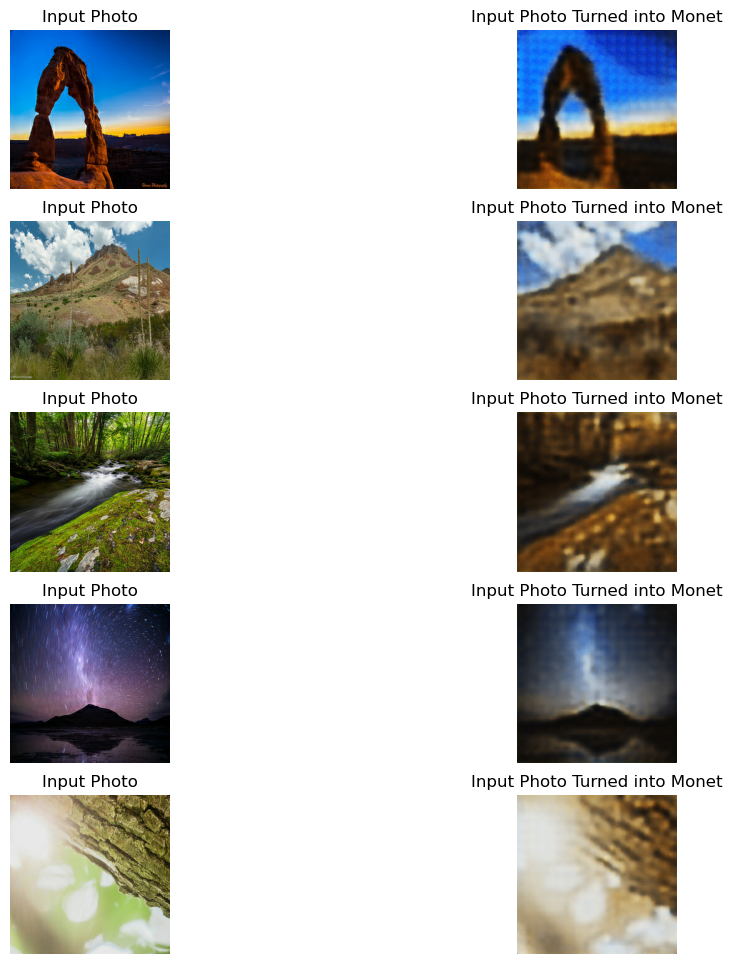

In [165]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Input Photo Turned into Monet")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

I am going to now create my submission file.

In [167]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../downloads/images/" + str(i) + ".jpg")
    i += 1

### Conclusion

Overall, I think this was a good model for the problem we were trying to solve. With only 10 epochs, we were able to turn regular photographs into Monet-esque "paintings" utilzing a classic GAN model. With additional epochs, we would be able to get even more accurate results.

There are a few additional things I could try to get a better result:
* Increase epochs. Keep in mind that doing so significantly increases the time spent fitting the model.
* Continue to optimize the parameters.
* Add additional layers to the generator and discriminator models.

However, given what I have accomplished, I think it is a good start, and I definitely learned a great amount about how to use GANs and how to modify photos to be more like art pieces.